#### made by Simona

## Define a structure and  rotation axis

##### Here is a RANDOM protein with a random ligand which was in the channel in a pdb file. I collected two points of the rotation axis between two parts of the structure (https://pymolwiki.org/index.php/RotationAxis) for a future axis direction difinition


PyMOL>draw_axis ('s1', 's2')
#################################################################################################
Transformation (TTT) matrix
   -0.89,     0.26,    -0.37,    94.60
   -0.06,    -0.87,    -0.48,   366.41
   -0.45,    -0.41,     0.79,   116.25
    0.00,     0.00,     0.00,     1.00
.................................................................................................

The direction cosines of the rotation axis is: -0.22, -0.24, 0.95
The angle of rotation is 170.14 degrees
The lenght of the translation vector along the rotation axis is 2.39 Angstroms
The distance between mass centers is 17.02 Angstroms
.................................................................................................

Lines to be used in a pml script to generate the axis

CYLINDER, 39.05, 151.50, 167.09, 52.06, 165.77, 110.28, 0.60, 1.00, 1.00, 1.00, 1.00, 0.00, 0.00, 0.0
cmd.load_cgo(obj, 170.14)

#####################################################################

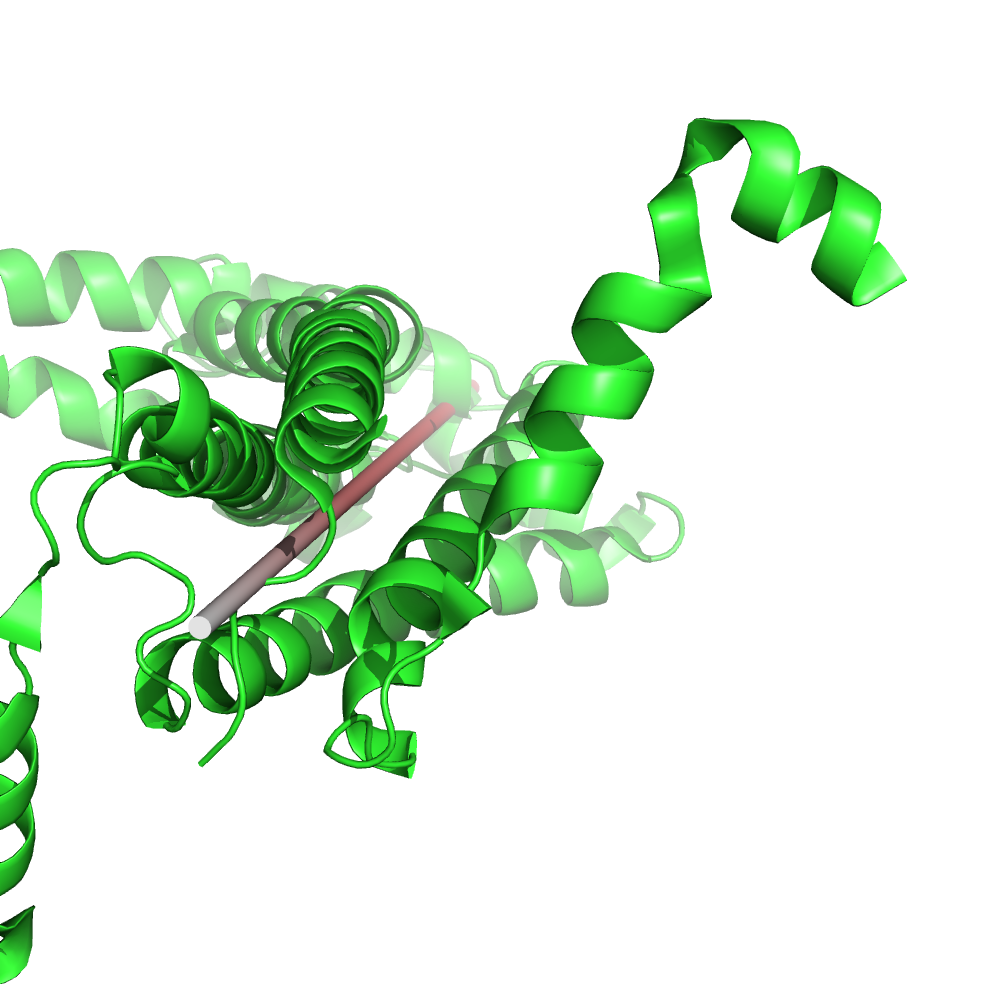

In [1]:
import pymol
from pymol import cmd, cgo
import IPython
import psico.fullinit
from vina import Vina
import numpy as np
import seaborn as sns

cmd.fetch(code='1q90',  type='pdb')

b = []
model = cmd.get_model('chain B and polymer')
for i in range(len(model.atom)):
    b.append(model.atom[i].resi)
start, end = int(b[0]), int(b[-1])


cmd.select('s1', 'resi {}-{} and chain B and polymer'.format(start, (end-start)//2))
cmd.select('s2', 'resi {}-{} and chain B and polymer'.format((end-start)//2, end))
cmd.run('draw_rotation_axis.py')
cmd.do("draw_axis ('s1', 's2')")

with open('axis.txt', 'r') as f:
    points = f.readline().split()
    
x1, y1, z1 =  float(points[0]), float(points[1]), float(points[2])
x2, y2, z2 = float(points[3]), float(points[4]), float(points[5])

print('rotation axis first point:', x1, y1, z1)
print('rotation axis second point:', x2, y2, z2)

cmd.do('''
hide everything
show cartoon, chain B
show cgo
''')
cmd.png('view.png', 1000, 1000)
IPython.display.Image('view.png', retina=True)


## Create receptor and ligand files

In [2]:
cmd.delete('all')
cmd.fetch(code='1q90',  type='pdb')
cmd.create('ligand', 'resi 901')
cmd.create('receptor', 'polymer and chain B')
obj_list = cmd.get_names('objects')
cmd.save(filename='receptor.pdb',format='pdb',selection='receptor')
cmd.save(filename='ligand.mol2',format='mol2',selection='ligand')
cmd.do('''
hide everything
show cartoon, receptor
show sticks, ligand
''')


PyMOL>hide everything
PyMOL>show cartoon, receptor
PyMOL>show sticks, ligand


## Gyration radius and COM

##### I did not use Rg for now as I built a rotational axis through the COM with an appropriate length

 Ray: render time: 11.67 sec. = 308.4 frames/hour (20.21 sec. accum.).


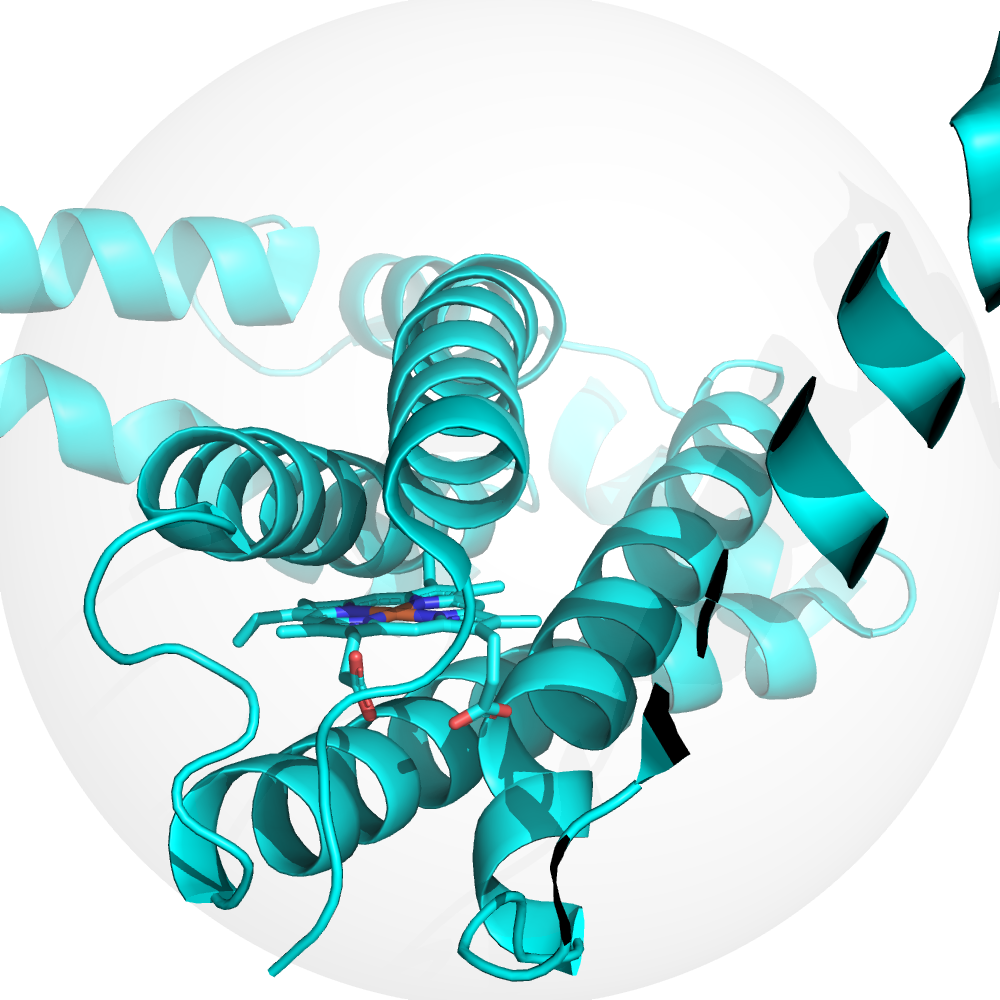

In [3]:
r = cmd.gyradius('receptor')
com = cmd.centerofmass('receptor')
sphere = [cgo.SPHERE, *com, r]
cmd.load_cgo(sphere, "plain_sphere")
cmd.set("cgo_transparency", 0.9)

cmd.png('view.png', 1000, 1000)
IPython.display.Image('view.png', retina=True)

## Coordinates for docking boxes (along the axis)

In [4]:
x0, y0, z0 = com[0], com[1], com[2]
t = np.arange(-0.5, 0.5, 0.05, dtype=float)
x = x0 + (x2-x1) * t 
y = y0 + (y2 - y1) * t 
z = z0 + (z2 - z1) *t
coordinates = []
for i in range(0, len(x)):
    coordinates.extend([[x[i], y[i], z[i]]])
coordinates

[[39.76772069519761, 153.24382175099475, 165.22129095022441],
 [40.418473396941295, 153.9573489539784, 162.38097409258765],
 [41.06922609868497, 154.67087615696207, 159.54065723495088],
 [41.71997880042865, 155.3844033599457, 156.70034037731412],
 [42.37073150217233, 156.09793056292938, 153.86002351967733],
 [43.02148420391601, 156.81145776591302, 151.01970666204056],
 [43.672236905659695, 157.52498496889666, 148.1793898044038],
 [44.32298960740337, 158.23851217188033, 145.33907294676703],
 [44.973742309147056, 158.95203937486397, 142.49875608913027],
 [45.62449501089073, 159.66556657784764, 139.65843923149347],
 [46.27524771263442, 160.37909378083128, 136.8181223738567],
 [46.926000414378095, 161.09262098381492, 133.97780551621995],
 [47.57675311612178, 161.8061481867986, 131.13748865858318],
 [48.227505817865456, 162.51967538978224, 128.2971718009464],
 [48.87825851960914, 163.2332025927659, 125.45685494330964],
 [49.52901122135282, 163.94672979574955, 122.61653808567287],
 [50.17976

## Protein and ligand pdbqt preporation

In [9]:
!/Users/ss/Desktop/vina/prepare_receptor4.py -r {'receptor.pdb'} -o {'receptor.pdbqt'}
!/Users/ss/Desktop/vina/prepare_ligand4.py  -l {'ligand.mol2'}  -o {'ligand.pdbqt'}

adding gasteiger charges to peptide
Sorry, there are no Gasteiger parameters available for atom ligand:B:HEC9011:FE


## Docking with different boxes

##### Its a super raw docking just using vina initial settings;  config file define box center and size 
###### p.s i couldnt use python vina because of the constant keernel death in jupyter 

In [10]:
energy = []
s = 0 

for i in coordinates:
    s += 1
    a = 'receptor = receptor.pdbqt\nligand = ligand.pdbqt\nout = all' + str(s) + '.pdbqt\ncenter_x = ' + str(i[0]) + '\ncenter_y = ' +  str(i[1]) + '\ncenter_z = ' + str(i[2]) + '\nsize_x = 11.25\nsize_y = 11.25\nsize_z = 11.25'
    with open('conf.txt', 'w') as f:
        f.write(a)
    !/Users/ss/Desktop/vina/vina --config conf.txt --log res.log
    with open('res.log', 'r') as f:
        for line in f:
            if line.startswith('   1'):
                energy.append(float(line.split()[1]))


#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Detected 4 CPUs
Reading input ... done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 167

Analyzing the binding site ... done.
Using random seed: -1740040164
Performing search ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
done.
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         12.5      0.000      0.000
   2         14.9      1.358      6.257
Writing output ... done.
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                  

Analyzing the binding site ... done.
Using random seed: -421838972
Performing search ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
done.
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1         33.0      0.000      0.000
   2         35.3      2.338      6.507
Writing output ... done.
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                   

Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: -2083254605
Performing search ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
done.
Refining results ... done.

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1        206.0      0.000      0.000
   2        208.7      4.460      5.271
Writing output ... done.
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistr

## no binding at all, still beautiful picture :):):):)

<AxesSubplot: >

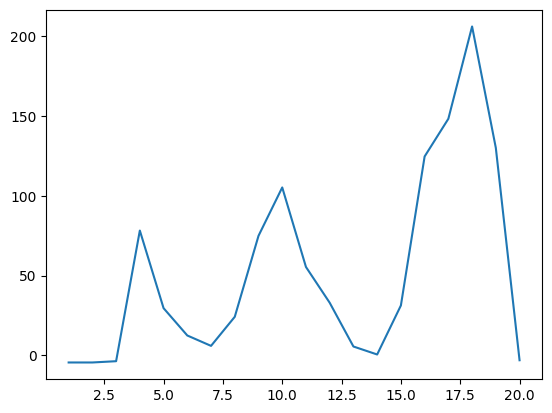

In [12]:
sns.lineplot(x = range(1, 21), y  = energy)


PyMOL>show sticks, organic
PyMOL>show cartoon, receptor
PyMOL>orient
 Ray: render time: 6.76 sec. = 532.4 frames/hour (48.28 sec. accum.).


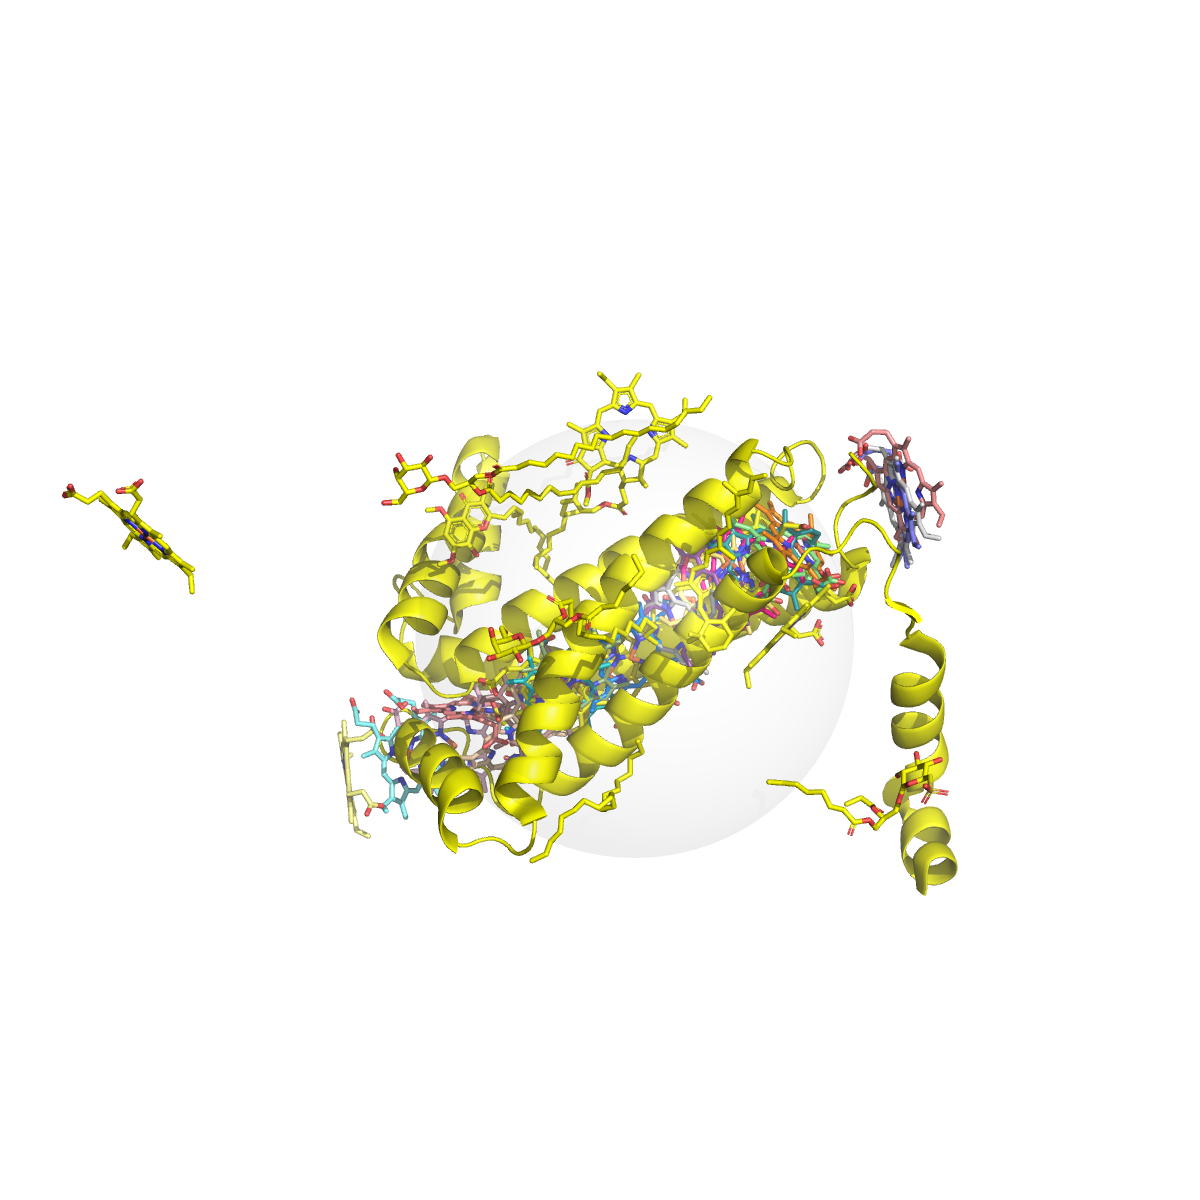

In [16]:
cmd.do('''
show sticks, organic
show cartoon, receptor
orient
''')
for i in range(1, 21):
    cmd.load('all{}.pdbqt'.format(i))

cmd.png('view.png', width=1200, height=1200, dpi=300, ray=1)
IPython.display.Image('view.png', retina=True)